# Import library and check versions of Cuda and CuDNN

In [2]:
import tensorflow as tf
from ParticleNet import get_particle_net
# Logging and learning control
import logging
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard


gpu = True
if not gpu:
# Establecer para que TensorFlow solo use CPU
  tf.config.set_visible_devices([], 'GPU')

# Verificar si solo se está usando CPU
  print("Dispositivos físicos disponibles:", tf.config.list_physical_devices('GPU'))

# Tu código de TensorFlow aquí
!export LD_LIBRARY_PATH=/usr/local/cuda/lib64:$LD_LIBRARY_PATH

# !export LD_LIBRARY_PATH=/mnt/c/Users/olmic/Desktop/Personal/Máster/TFM/Código/TFM-CTLearn/cudnn/cudnn-linux-x86_64-8.9.2.26_cuda11-archive/lib:$LD_LIBRARY_PATH
# !export CUDNN_INCLUDE_DIR=/mnt/c/Users/olmic/Desktop/Personal/Máster/TFM/Código/TFM-CTLearn/cudnn/cudnn-linux-x86_64-8.9.2.26_cuda11-archive/include


In [9]:
print("CUDA version:", tf.sysconfig.get_build_info()["cuda_version"])
print("CuDNN version:", tf.sysconfig.get_build_info()["cudnn_version"])

CUDA version: 11.8
CuDNN version: 8


In [10]:
# Mostramos la versión de tensorflow instalada
print(tf.__version__)

2.14.1


# Configure Log Dir, EarlyStopping and ReduceLROnPlateau

In [1]:
import tensorflow as tf

def f1_score(y_true, y_pred):
    y_pred = tf.round(y_pred)
    tp = tf.reduce_sum(tf.cast(y_true * y_pred, 'float'), axis=0)
    fp = tf.reduce_sum(tf.cast((1 - y_true) * y_pred, 'float'), axis=0)
    fn = tf.reduce_sum(tf.cast(y_true * (1 - y_pred), 'float'), axis=0)

    p = tp / (tp + fp + tf.keras.backend.epsilon())
    r = tp / (tp + fn + tf.keras.backend.epsilon())

    f1 = 2 * p * r / (p + r + tf.keras.backend.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return tf.reduce_mean(f1)

2024-07-12 20:30:07.606072: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-12 20:30:07.642829: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-12 20:30:07.642856: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-12 20:30:07.642873: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-12 20:30:07.648576: I tensorflow/core/platform/cpu_feature_g

In [7]:
import os

def generate_call_backs(log_dir, extra_metric = None, reduce_lr_options = dict({"reduce_lr":True}), early_stopping_options = dict({"early_stop":True}), checkpoint_options = dict({"checkpoint":True})):
    # Configurar el logger
    logger = logging.getLogger(__name__)
    logger.setLevel(logging.INFO)
    if not os.path.exists(log_dir):
        os.makedirs(log_dir)
    log_file = log_dir+'training.log'
    file_handler = logging.FileHandler(log_file)
    file_handler.setLevel(logging.INFO)

    # Crear un formato para los logs
    formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
    file_handler.setFormatter(formatter)

    # Añadir el manejador de archivo al logger
    logger.addHandler(file_handler)

    # Callback personalizado para logging
    class LoggingCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs=None):
            if extra_metric is not None:
                logger.info(f"Epoch {epoch + 1}, Loss: {logs['loss']}, Accuracy: {logs['accuracy']}, {extra_metric}: {logs[extra_metric]}, Val Loss: {logs['val_loss']}, Val Accuracy: {logs['val_accuracy']}, Val {extra_metric}: {logs['val_'+extra_metric]}")
            else:
                logger.info(f"Epoch {epoch + 1}, Loss: {logs['loss']}, Accuracy: {logs['accuracy']}, Val Loss: {logs['val_loss']}, Val Accuracy: {logs['val_accuracy']}")

    # Configurar TensorFlow para usar el logger de Python
    tf.get_logger().setLevel('INFO')

    if reduce_lr_options.get("reduce_lr", False):
        # Callback para reducir el learning rate
        reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
            monitor = reduce_lr_options.get("monitor", "val_loss"),
            factor = reduce_lr_options.get("factor", 0.1),
            patience = reduce_lr_options.get("patience", 5),
            verbose = 1,
            mode = reduce_lr_options.get("mode", "auto"),
            min_delta = reduce_lr_options.get("min_delta", 0.0001),
            cooldown = reduce_lr_options.get("cooldown",2),
            min_lr = reduce_lr_options.get("min_lr",0.00001)
        )
    
    if early_stopping_options.get("early_stop", False):
        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor = early_stopping_options.get("monitor", "val_loss"),
            patience = early_stopping_options.get("patience", 5),
            restore_best_weights = early_stopping_options.get("restore_best_weights", True)
        )

    # Configurar el callback de TensorBoard
    tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

    # Prepare model model saving directory.
    save_dir = log_dir + 'model_checkpoints'
    model_name = '%s_model.{epoch:03d}.h5' % 'PCT_low_data'
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    filepath = os.path.join(save_dir, model_name)

    if checkpoint_options.get("checkpoint", False):
        checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=filepath,
                                    monitor=checkpoint_options.get("monitor", 'val_loss'),
                                    verbose=1,
                                    save_best_only=True,
                                    mode=checkpoint_options.get("mode", 'auto'))

    return [LoggingCallback(), reduce_lr, early_stopping, tensorboard_callback, checkpoint]


In [12]:
log_dir = "../logs/PC_low_data_test/"
callbacks = generate_call_backs(log_dir)

# Create Model

In [13]:
# Generación de datos
from DataLoader import PCDataGenerator
import h5py
import numpy as np

data_path = "../data/dataset_500_rel_coords.h5"
# Dividir el dataset en train, test y validation
with h5py.File(data_path, 'r') as f:
    all_indices = list(f.keys())

# Suponiendo que quieres una división 70% train, 15% validation, 15% test
np.random.seed(0)
np.random.shuffle(all_indices)
train_split = int(0.7 * len(all_indices))
val_split = int(0.85 * len(all_indices))

train_indices = all_indices[:train_split]
val_indices = all_indices[train_split:val_split]
test_indices = all_indices[val_split:]

# Crear generadores para cada partición
batch_size = 16
train_data = PCDataGenerator(data_path, train_indices, batch_size=batch_size, shuffle=True)
val_data = PCDataGenerator(data_path, val_indices, batch_size=batch_size, shuffle=True)
test_data = PCDataGenerator(data_path, test_indices, batch_size=batch_size, shuffle=False)

In [14]:
import yaml

with open('PN_config.yml', 'r') as myconfig:
  config = yaml.load(myconfig, Loader=yaml.Loader)
  
model_config = config["Model Parameters"]
model_config["model_directory"] = "./"
model, inputs = get_particle_net(train_data, model_config)
model.summary()

2024-07-12 19:14:08.438646: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-12 19:14:08.444171: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-12 19:14:08.444203: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-12 19:14:08.445614: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-12 19:14:08.445644: I tensorflow/compile

Model: "ParticleNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 mask (InputLayer)           [(None, 500, 1)]             0         []                            
                                                                                                  
 MaskCoordShiftLayer (MaskC  (None, 500, 1)               0         ['mask[0][0]']                
 oordShiftLayer)                                                                                  
                                                                                                  
 points (InputLayer)         [(None, 500, 2)]             0         []                            
                                                                                                  
 AddShifttoCoordLayer_layer  (None, 500, 2)               0         ['MaskCoordShiftLaye

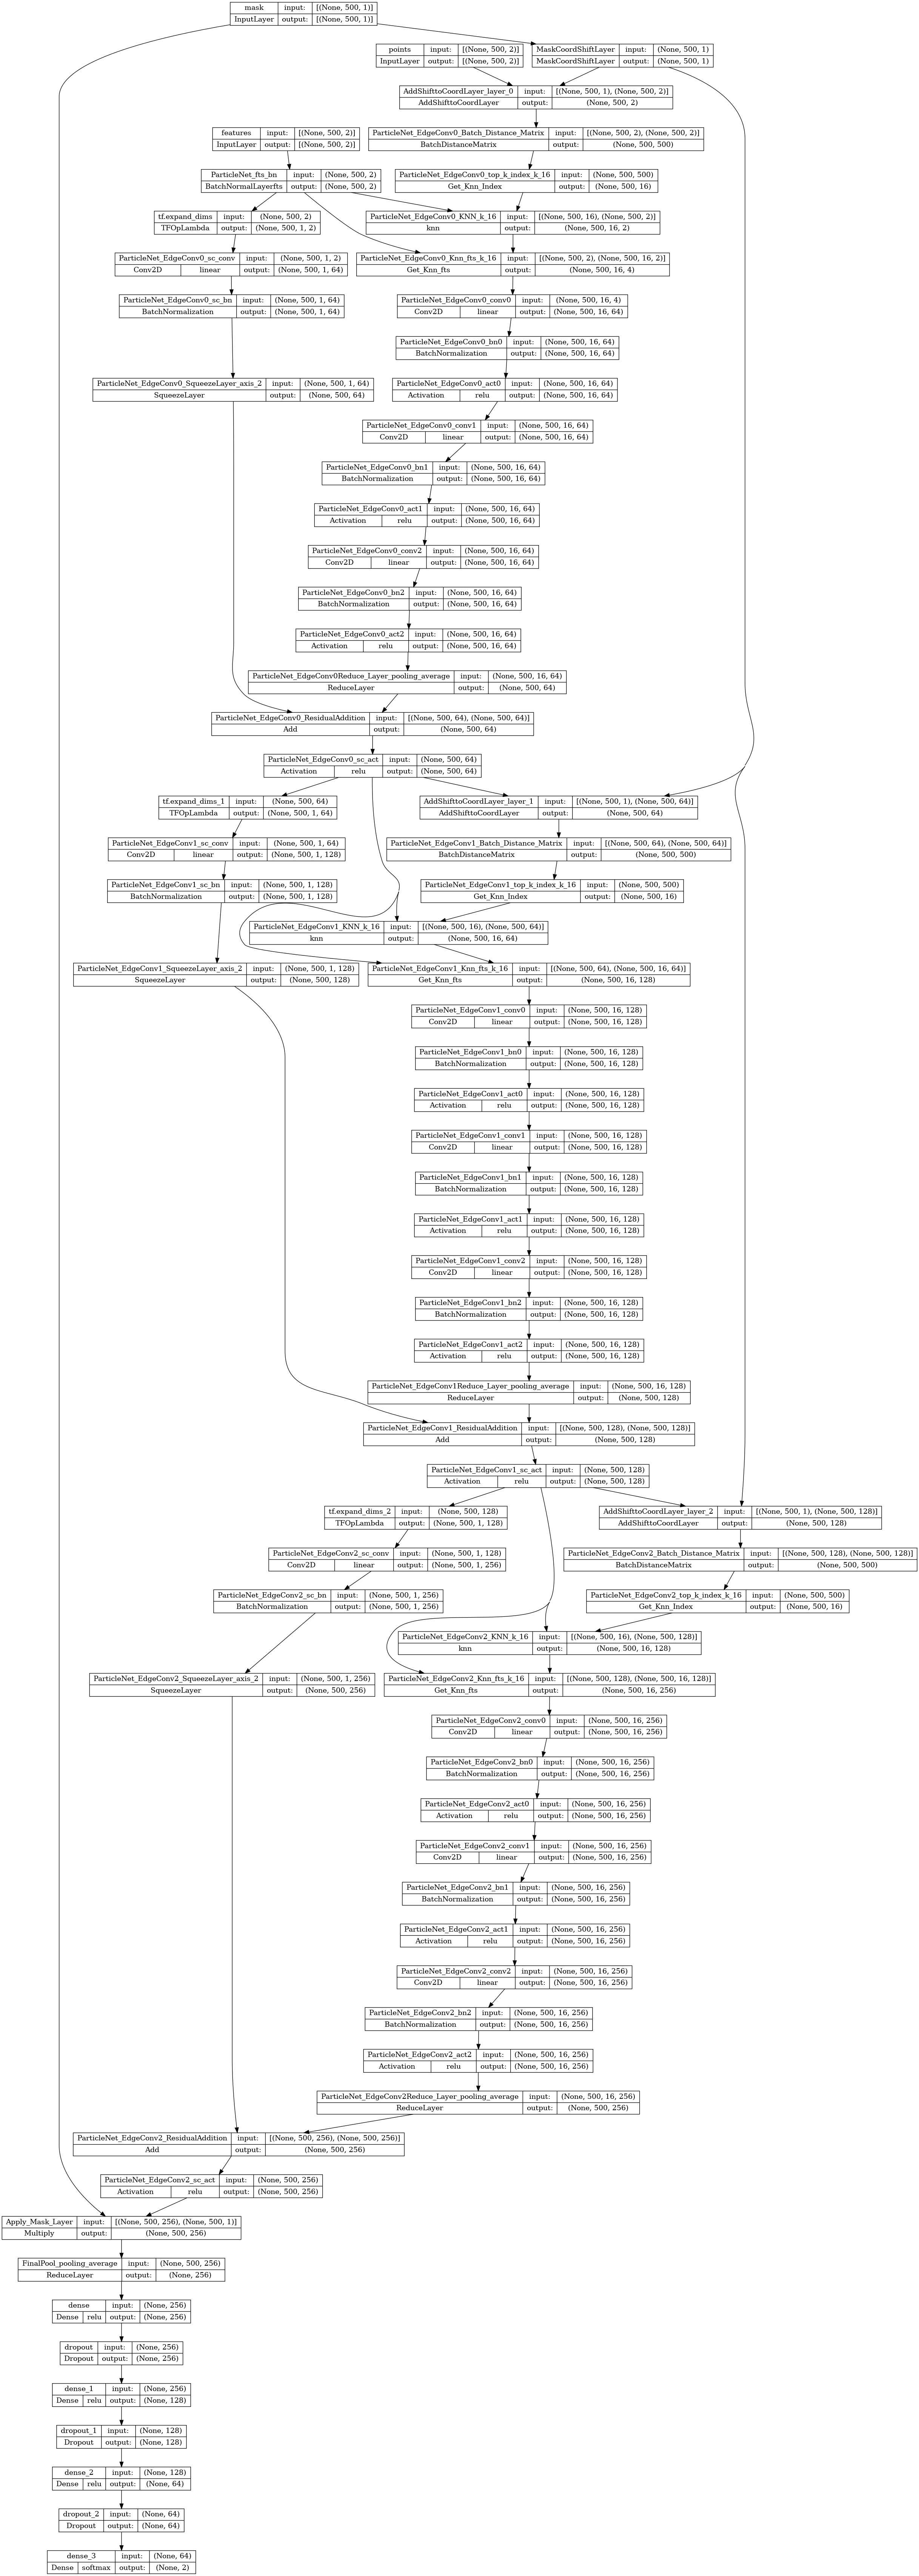

In [15]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names= True, show_layer_activations = True)

In [16]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              metrics=['accuracy'])

# Run Model

## Train Model

In [ ]:
# Entrenar el modelo
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    callbacks=callbacks
)

## Test Model

In [ ]:
# Evaluar el modelo
test_loss, test_acc = model.evaluate(test_data)
logger.info(f'Test accuracy: {test_acc}')

In [ ]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Asume que tienes un modelo entrenado llamado `model`
# y un generador de datos de prueba llamado `test_generator`

# Realiza predicciones sobre el conjunto de datos de prueba
y_pred_probs = model.predict(test_data)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Obtener las etiquetas reales
y_true_vectors = np.concatenate([y for x, y in test_data], axis=0)
y_true_classes = np.argmax(y_true_vectors, axis=1)

76/76 [==============================] - 5s 66ms/step


In [ ]:

# Calcula la matriz de confusión
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
print('Confusion Matrix:')
print(conf_matrix)

# Calcula precision, recall, f1-score, y otras métricas
classification_rep = classification_report(y_true_classes, y_pred_classes)
print('Classification Report:')
print(classification_rep)


Confusion Matrix:
[[1011    0]
 [ 205    0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.83      1.00      0.91      1011
           1       0.00      0.00      0.00       205

    accuracy                           0.83      1216
   macro avg       0.42      0.50      0.45      1216
weighted avg       0.69      0.83      0.75      1216

Precision: 0.6912500270515928
Recall: 0.8314144736842105
F1 Score: 0.7548810353791978


/home/olmoa/anaconda3/envs/ctlearn-cluster/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/olmoa/anaconda3/envs/ctlearn-cluster/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/olmoa/anaconda3/envs/ctlearn-cluster/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

# Class Weights

In [1]:
import tensorflow as tf
from ParticleNet import get_particle_net
# Logging and learning control
import logging
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard


gpu = True
if not gpu:
# Establecer para que TensorFlow solo use CPU
  tf.config.set_visible_devices([], 'GPU')

# Verificar si solo se está usando CPU
  print("Dispositivos físicos disponibles:", tf.config.list_physical_devices('GPU'))

# Tu código de TensorFlow aquí
!export LD_LIBRARY_PATH=/usr/local/cuda/lib64:$LD_LIBRARY_PATH

# !export LD_LIBRARY_PATH=/mnt/c/Users/olmic/Desktop/Personal/Máster/TFM/Código/TFM-CTLearn/cudnn/cudnn-linux-x86_64-8.9.2.26_cuda11-archive/lib:$LD_LIBRARY_PATH
# !export CUDNN_INCLUDE_DIR=/mnt/c/Users/olmic/Desktop/Personal/Máster/TFM/Código/TFM-CTLearn/cudnn/cudnn-linux-x86_64-8.9.2.26_cuda11-archive/include


2024-07-13 13:48:17.873801: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-13 13:48:17.913246: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-13 13:48:17.913274: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-13 13:48:17.913317: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-13 13:48:17.924445: I tensorflow/core/platform/cpu_feature_g

In [2]:
# Generación de datos
from DataLoader import PCDataGenerator
import h5py
import numpy as np

data_path = "../data/dataset_500_rel_coords.h5"
# Dividir el dataset en train, test y validation
with h5py.File(data_path, 'r') as f:
    all_indices = list(f.keys())

# Suponiendo que quieres una división 70% train, 15% validation, 15% test
np.random.seed(0)
np.random.shuffle(all_indices)
train_split = int(0.7 * len(all_indices))
val_split = int(0.85 * len(all_indices))

train_indices = all_indices[:train_split]
val_indices = all_indices[train_split:val_split]
test_indices = all_indices[val_split:]

# Crear generadores para cada partición
batch_size = 16
train_data = PCDataGenerator(data_path, train_indices, batch_size=batch_size, shuffle=True)
val_data = PCDataGenerator(data_path, val_indices, batch_size=batch_size, shuffle=True)
test_data = PCDataGenerator(data_path, test_indices, batch_size=batch_size, shuffle=False)

In [3]:
import yaml

with open('PN_config.yml', 'r') as myconfig:
  config = yaml.load(myconfig, Loader=yaml.Loader)
  
model_config = config["Model Parameters"]
model_config["model_directory"] = "./"
model, inputs = get_particle_net(train_data, model_config)
model.summary()

2024-07-13 13:48:22.916520: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-13 13:48:22.925193: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-13 13:48:22.925239: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-13 13:48:22.926860: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-13 13:48:22.926899: I tensorflow/compile

Model: "ParticleNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 mask (InputLayer)           [(None, 500, 1)]             0         []                            
                                                                                                  
 MaskCoordShiftLayer (MaskC  (None, 500, 1)               0         ['mask[0][0]']                
 oordShiftLayer)                                                                                  
                                                                                                  
 points (InputLayer)         [(None, 500, 2)]             0         []                            
                                                                                                  
 AddShifttoCoordLayer_layer  (None, 500, 2)               0         ['MaskCoordShiftLaye

In [6]:
losses = tf.keras.losses.CategoricalCrossentropy(reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE)
AUC = tf.keras.metrics.AUC()
metrics = [
    tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
    tf.keras.metrics.AUC(name="auc"),
]
model.compile(loss=losses,
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              metrics=metrics)

In [8]:
log_dir = '../logs/PC_low_data_test_weighted_auc/'
callbacks_weighted = generate_call_backs(log_dir, extra_metric="auc")
# Entrenar el modelo
history = model.fit(
    train_data,
    validation_data=val_data,
    class_weight=train_data.class_weight,
    epochs=10,
    callbacks=callbacks_weighted
)

2024-07-13 12:29:13.091053: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Epoch 1/10


2024-07-13 12:29:17.509801: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8902
2024-07-13 12:29:17.702800: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-07-13 12:29:19.700528: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f58df11ea60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-07-13 12:29:19.700561: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-07-13 12:29:19.706986: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-13 12:29:19.801545: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


358/358 [==============================] - ETA: 0s - loss: 0.7251 - accuracy: 0.4475 - auc: 0.4163
Epoch 1: val_loss improved from inf to 0.69699, saving model to ../logs/PC_low_data_test_weighted_auc/model_checkpoints/PCT_low_data_model.001.h5


/home/olmoa/anaconda3/envs/ctlearn-cluster/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


358/358 [==============================] - 64s 150ms/step - loss: 0.7251 - accuracy: 0.4475 - auc: 0.4163 - val_loss: 0.6970 - val_accuracy: 0.2985 - val_auc: 0.2072 - lr: 0.0100
Epoch 2/10
358/358 [==============================] - ETA: 0s - loss: 0.6824 - accuracy: 0.6454 - auc: 0.6901
Epoch 2: val_loss improved from 0.69699 to 0.66963, saving model to ../logs/PC_low_data_test_weighted_auc/model_checkpoints/PCT_low_data_model.002.h5
358/358 [==============================] - 54s 151ms/step - loss: 0.6824 - accuracy: 0.6454 - auc: 0.6901 - val_loss: 0.6696 - val_accuracy: 0.8232 - val_auc: 0.7995 - lr: 0.0100
Epoch 3/10
358/358 [==============================] - ETA: 0s - loss: 0.6797 - accuracy: 0.7210 - auc: 0.7492
Epoch 3: val_loss improved from 0.66963 to 0.64868, saving model to ../logs/PC_low_data_test_weighted_auc/model_checkpoints/PCT_low_data_model.003.h5
358/358 [==============================] - 55s 154ms/step - loss: 0.6797 - accuracy: 0.7210 - auc: 0.7492 - val_loss: 0.64

## Evaluación

In [9]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score

# Asume que tienes un modelo entrenado llamado `model`
# y un generador de datos de prueba llamado `test_generator`

# Realiza predicciones sobre el conjunto de datos de prueba
y_pred_probs = model.predict(test_data)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Obtener las etiquetas reales
y_true_vectors = np.concatenate([y for x, y in test_data], axis=0)
y_true_classes = np.argmax(y_true_vectors, axis=1)

76/76 [==============================] - 6s 67ms/step


In [13]:

# Calcula la matriz de confusión
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
print('Confusion Matrix:')
print(conf_matrix)

# Calcula precision, recall, f1-score, y otras métricas
classification_rep = classification_report(y_true_classes, y_pred_classes)
print('Classification Report:')
print(classification_rep)

Confusion Matrix:
[[ 14 997]
 [  1 204]]
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.01      0.03      1011
           1       0.17      1.00      0.29       205

    accuracy                           0.18      1216
   macro avg       0.55      0.50      0.16      1216
weighted avg       0.80      0.18      0.07      1216



AUC: 0.504484813394128


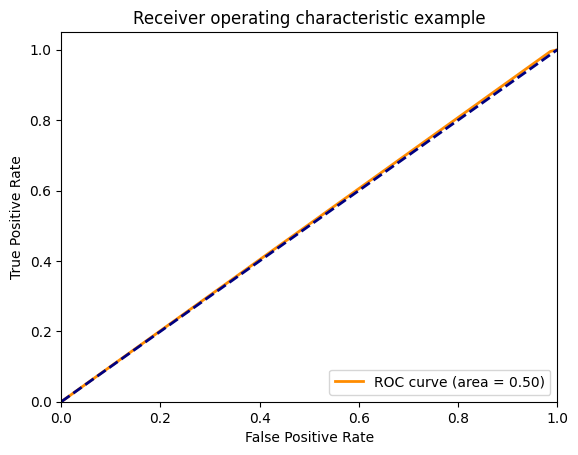

In [12]:

# Importamos auc
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

# Calculamos el AUC
auc_score = roc_auc_score(y_true_classes, y_pred_classes)
print(f'AUC: {auc_score}')

# Calculamos la curva ROC
fpr, tpr, _ = roc_curve(y_true_classes, y_pred_classes)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()
